## Problem set 3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7B84DF7C8>,
      dtype=object)

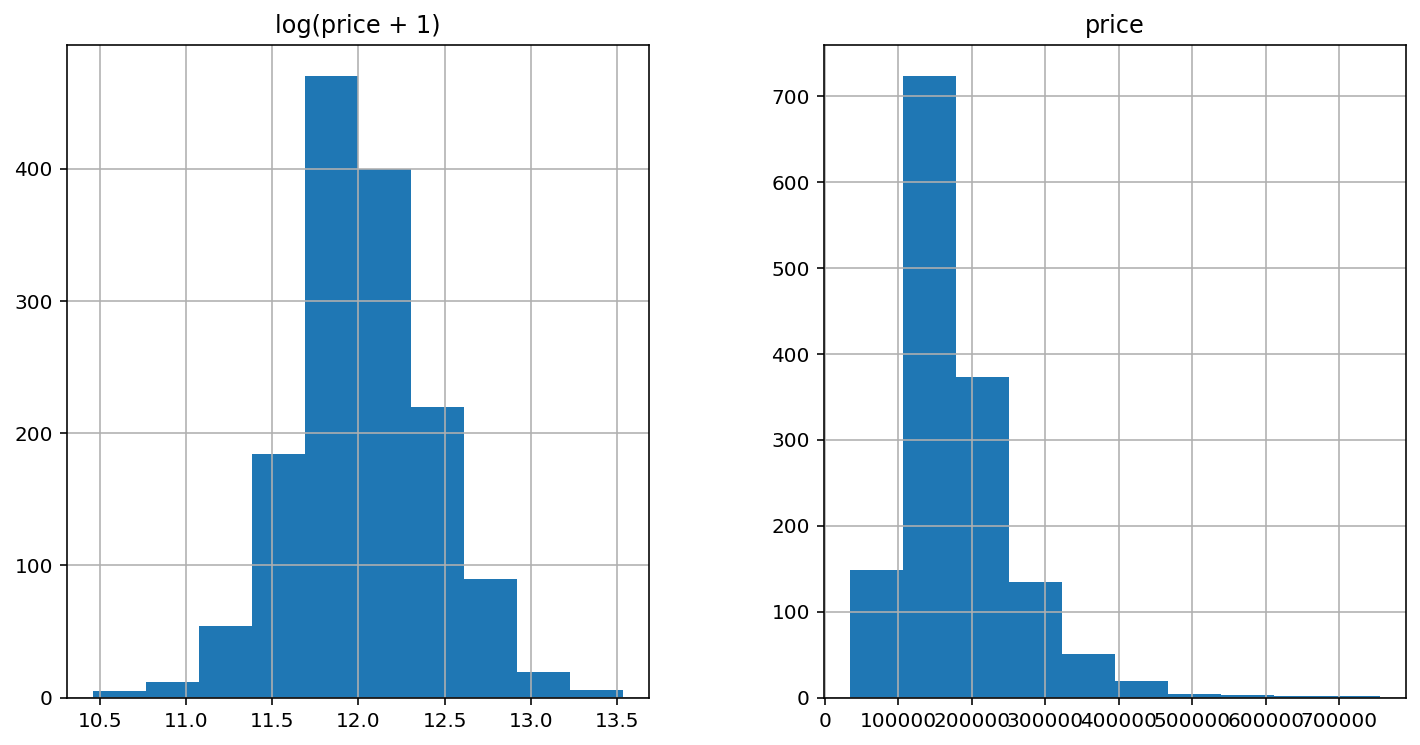

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [7]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [9]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


## 2. Then run a ridge regression using α= 0.1.Make a submission of this prediction, what is the RMSE you get?

[207291.41324549 195516.62594643 216701.5504103  ... 282045.10488721
 142132.38128086 140940.50867708]


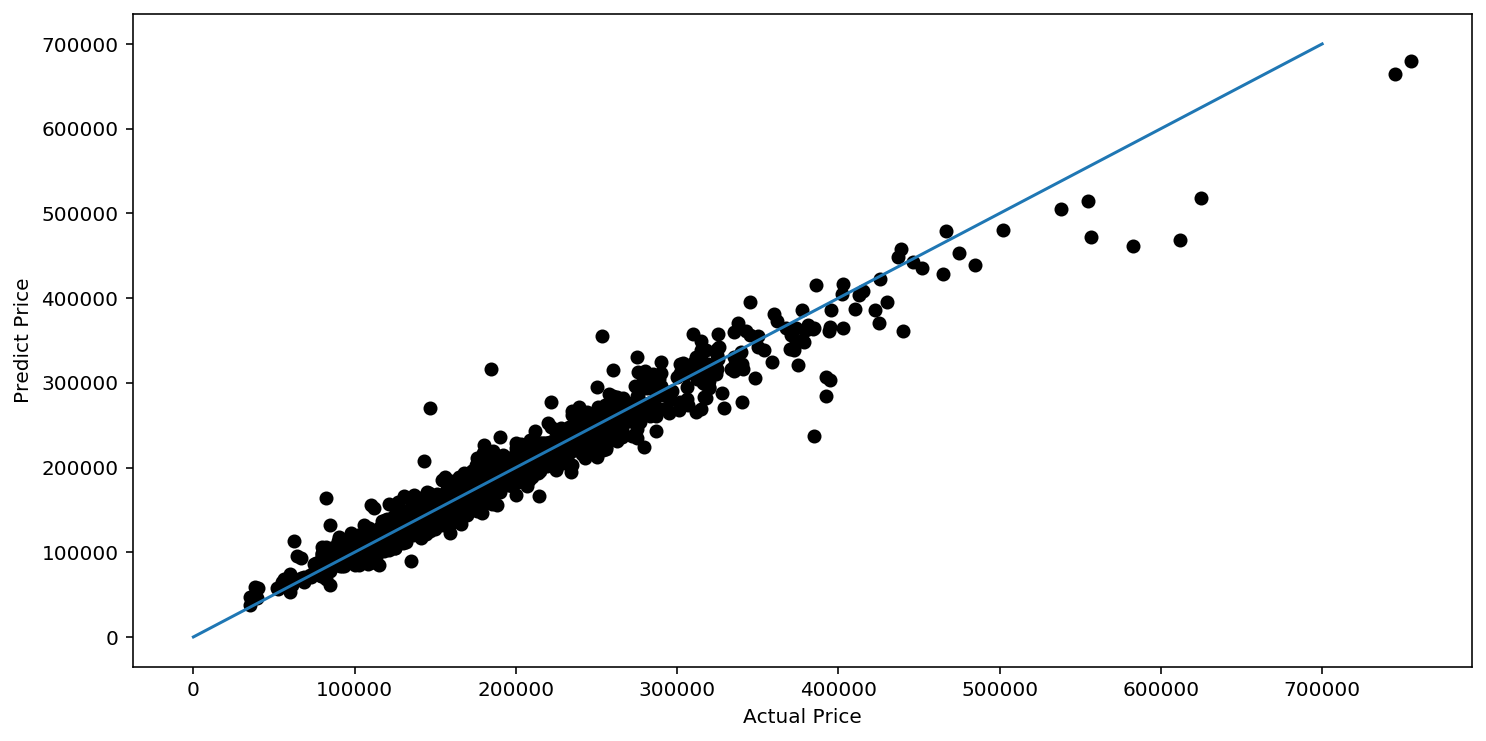

In [10]:
model_ridge = Ridge(alpha = 0.1)
model_ridge.fit(X_train, y)
ypred = model_ridge.predict(X_train)
y_pred = np.expm1(ypred)
print(y_pred)
plt.scatter(np.expm1(y), y_pred, color='black')
plt.xlabel("Actual Price")
plt.ylabel("Predict Price")
plt.plot(range(700000),range(700000))

In [11]:
testset = test['Id']
ypred1 = model_ridge.predict(X_test)
prices = np.expm1(ypred1)

prediction = pd.DataFrame({ 'Id': testset, 'SalePrice': np.round(prices, 3) })
print(prediction.head())

prediction.to_csv('submission.csv', header=['Id', 'SalePrice'], index=False)

     Id   SalePrice
0  1461  121519.487
1  1462  159637.898
2  1463  187900.728
3  1464  200719.158
4  1465  199280.935


### Score from kaggle is 0.1309

<img src="Kaggle Submission 1.png" alt="Score" width="500"/>

## 3. Compare a ridge regression and a lasso regression model.  Optimize the alphas using cross validation.  What is the best score you can get from a single ridge regression model and from a single lasso model?

In [12]:
# for Rigde regression
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [13]:
bestalpharidge = alphas[cv_ridge.index(min(cv_ridge))]
print("The best alpha from the list is "+str(bestalpharidge))

The best alpha from the list is 10


In [14]:
print("The best score I can get from a single Ridge regression is "+str(rmse_cv(Ridge(alpha = 10)).mean()))

The best score I can get from a single Ridge regression is 0.1273373466867077


Text(0, 0.5, 'rmse')

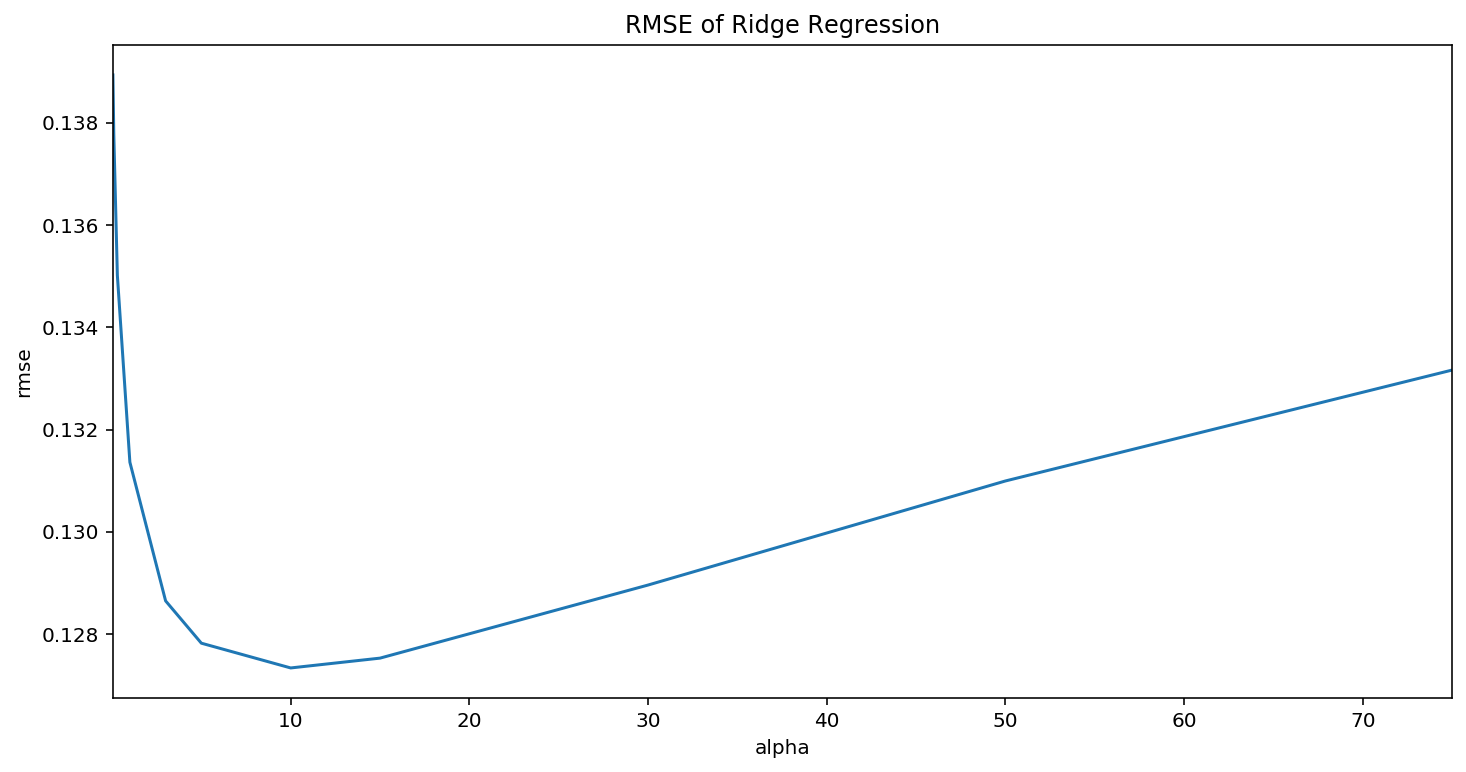

In [15]:
cv_ridgeplot = pd.Series(cv_ridge, index = alphas)
cv_ridgeplot.plot(title = "RMSE of Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
# for Lasso regression
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_lasso = [rmse_cv(LassoCV(alphas = [alpha]).fit(X_train, y)).mean() for alpha in alphas]

In [17]:
bestalphalasso = alphas[cv_lasso.index(min(cv_lasso))]
print("The best alpha from the list is "+str(bestalphalasso))

The best alpha from the list is 0.05


In [18]:
print("The best score I can get from a single Lasso regression is "+str(rmse_cv(LassoCV(alphas = [0.05]).fit(X_train, y)).mean()))

The best score I can get from a single Lasso regression is 0.18403762011012667


Text(0, 0.5, 'rmse')

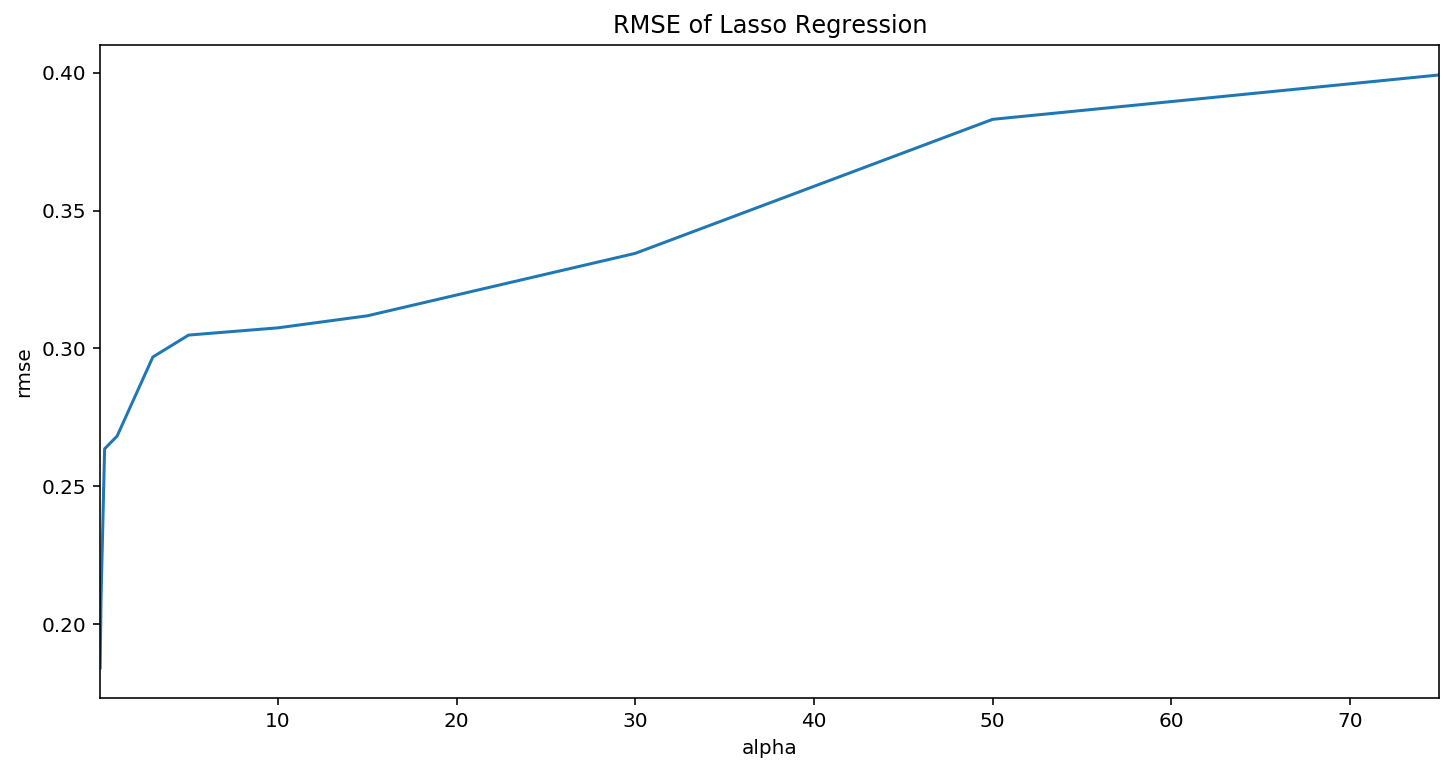

In [19]:
cv_lassoplot = pd.Series(cv_lasso, index = alphas)
cv_lassoplot.plot(title = "RMSE of Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")

## 4. Plot thel0 norm (number of nonzeros) of the coefficients that lasso produces as you vary thestrength of regularization parameter alpha.

In [20]:
coeflist = []
for a in alphas:
    model_lasso = LassoCV(alphas = [a]).fit(X_train, y)
    coeflist.append(sum(pd.Series(model_lasso.coef_, index = X_train.columns)!= 0))
coeflist

[9, 8, 3, 3, 2, 1, 1, 1, 1, 1, 0]

Text(0, 0.5, 'number of nonzeros')

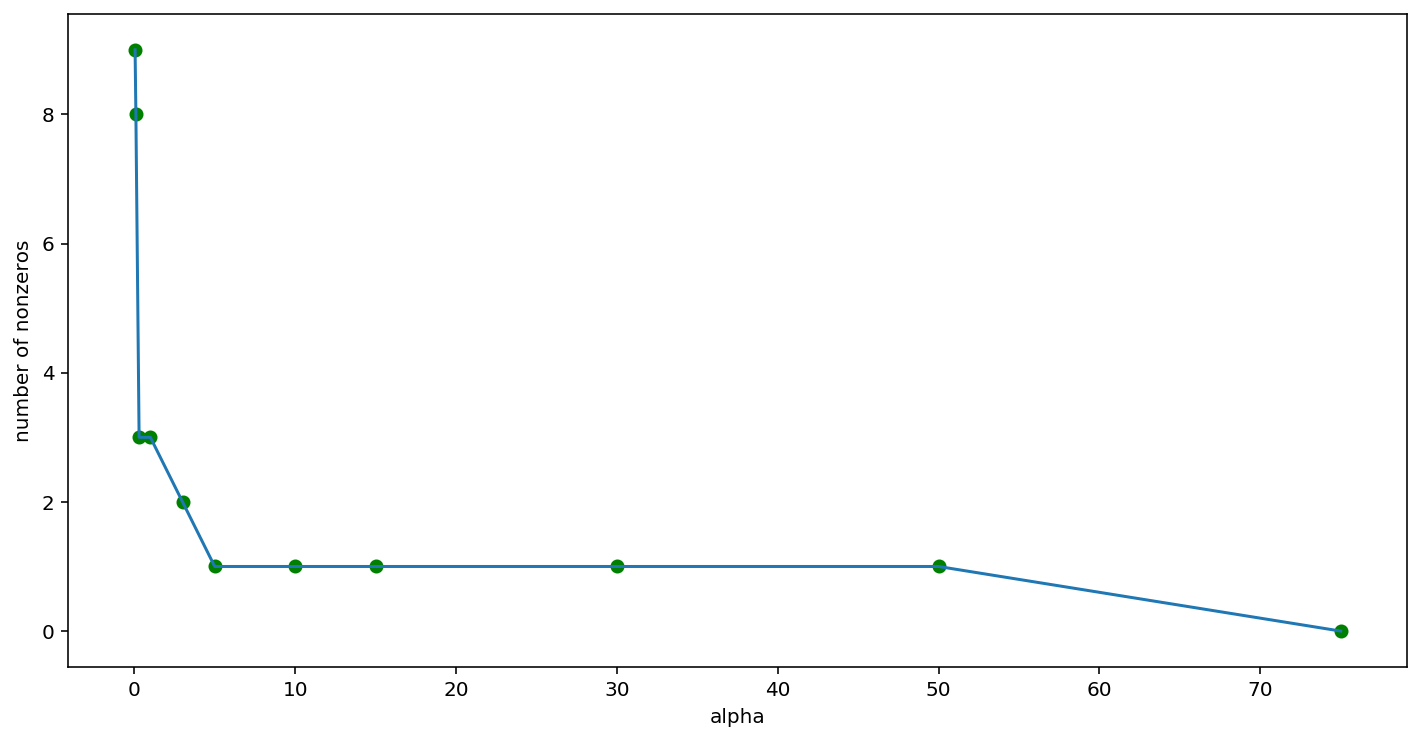

In [21]:
plt.plot(alphas,coeflist)
plt.scatter(alphas, coeflist, color = "g")
plt.xlabel('alpha')
plt.ylabel('number of nonzeros')

## 5. Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking).  Be careful not to overfit.What score can you get?

## Option 1 include both outputs as two features:

In [22]:
l1 = LassoCV(alphas = [0.05])
l1.fit(X_train,y)
ypred = l1.predict(X_train)

Xtrain = X_train.copy()
Xtrain['lassopred'] =  np.expm1(ypred)
Xtest = X_test.copy()
Xtest['lassopred'] =  np.expm1(l1.predict(X_test))


r1 = Ridge(alpha = 10)
r1.fit(X_train, y)
ypred1 = r1.predict(X_train)

Xtrain['ridgepred'] =  np.expm1(ypred1)
Xtest['ridgepred'] =  np.expm1(r1.predict(X_test))

In [25]:
r2 = Ridge(alpha = 10).fit(Xtrain,y)
r2.score(Xtrain,y)

0.9346083024967289

In [29]:
testset = test['Id']
ypred2 = r2.predict(Xtest)
prices = np.expm1(ypred2)

prediction1 = pd.DataFrame({ 'Id': testset, 'SalePrice': np.round(prices, 3) })
print(prediction1.head())

prediction1.to_csv('submission1.csv', header=['Id', 'SalePrice'], index=False)

     Id   SalePrice
0  1461  126856.481
1  1462  152196.559
2  1463  184886.286
3  1464  201221.946
4  1465  195235.020


### Score doesn't change

<img src="Kaggle Submission 2.png" alt="Score" width="500"/>

## Option 2 take the average of two outputs and add as one feature:

In [37]:
l1 = LassoCV(alphas = [0.05])
l1.fit(X_train,y)
l1pred = l1.predict(X_train)

r1 = Ridge(alpha = 10)
r1.fit(X_train, y)
r1pred = r1.predict(X_train)


Xtrain2 = X_train.copy()
Xtrain2['pred'] =  (l1pred+r1pred)/2

Xtest1 = X_test.copy()
Xtest1['pred'] =  (l1.predict(X_test)+r1.predict(X_test))/2
Xtrain2

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,pred
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.000000,...,0,0,1,0,0,0,0,1,0,12.296860
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.000000,...,0,0,1,0,0,0,0,1,0,12.095756
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.000000,...,0,0,1,0,0,0,0,1,0,12.280476
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.000000,...,0,0,1,1,0,0,0,0,0,12.019673
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.000000,...,0,0,1,0,0,0,0,1,0,12.622636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,4.143135,8.976894,6,5,1999,2000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0,1,0,12.065954
1456,3.044522,4.454347,9.486152,6,6,1978,1988,4.787492,6.673298,5.099866,...,0,0,1,0,0,0,0,1,0,12.169923
1457,4.262680,4.204693,9.109746,7,9,1941,2006,0.000000,5.620401,0.000000,...,0,0,1,0,0,0,0,1,0,12.304680
1458,3.044522,4.234107,9.181735,5,6,1950,1996,0.000000,3.912023,6.937314,...,0,0,1,0,0,0,0,1,0,11.807332


In [36]:
r3 = Ridge(alpha = 10).fit(Xtrain2,y)
r3.score(Xtrain2,y)

0.9304113383331404

In [38]:
Xtest1

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,pred
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0,0,1,0,0,0,0,1,0,11.808862
1,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0,0,1,0,0,0,0,1,0,11.899526
2,4.110874,4.317488,9.534668,5,5,1997,1998,0.000000,6.674561,0.000000,...,0,0,1,0,0,0,0,1,0,12.070355
3,4.110874,4.369448,9.208238,6,6,1998,1998,3.044522,6.401917,0.000000,...,0,0,1,0,0,0,0,1,0,12.180487
4,4.795791,3.784190,8.518392,8,5,1992,1992,0.000000,5.575949,0.000000,...,0,0,1,0,0,0,0,1,0,12.208998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,4,7,1970,1970,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0,1,0,11.378681
1455,5.081404,3.091042,7.546974,4,5,1970,1970,0.000000,5.533389,0.000000,...,0,0,1,1,0,0,0,0,0,11.499429
1456,3.044522,5.081404,9.903538,5,7,1960,1996,0.000000,7.110696,0.000000,...,0,0,1,1,0,0,0,0,0,12.069389
1457,4.454347,4.143135,9.253591,5,5,1992,1992,0.000000,5.823046,0.000000,...,0,0,1,0,0,0,0,1,0,11.719710


In [39]:
testset = test['Id']
ypred3 = r3.predict(Xtest1)
prices = np.expm1(ypred3)

prediction1 = pd.DataFrame({ 'Id': testset, 'SalePrice': np.round(prices, 3) })
print(prediction1.head())

prediction1.to_csv('submission3.csv', header=['Id', 'SalePrice'], index=False)

     Id   SalePrice
0  1461  119030.534
1  1462  153156.062
2  1463  181161.855
3  1464  197904.270
4  1465  200487.449


<img src="Kaggle Submission 3.png" alt="Score" width="500"/>

### Score improves a a little bit 😁, becomes 0.12227